In [1]:
#adding population data to grid cells. 

import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import time
import numpy as np
import geopandas as gpd
import pandas as pd
from rasterstats import zonal_stats
import pandas as pd
import numpy as np
import folium
import streamlit as st
import geopandas as gpd
from pathlib import Path
from shapely.geometry import Point
from colour import Color
from shapely.geometry import box
from shapely.strtree import STRtree
import contextily as ctx

import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask.array as da
import dask_geopandas as dgd

%matplotlib inline



Can't load requested DLL: C:\Users\linss\micromamba\envs\geoenv\Library\lib\gdalplugins\gdal_FITS.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Users\linss\micromamba\envs\geoenv\Library\lib\gdalplugins\gdal_FITS.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Users\linss\micromamba\envs\geoenv\Library\lib\gdalplugins\gdal_GRIB.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Users\linss\micromamba\envs\geoenv\Library\lib\gdalplugins\gdal_GRIB.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Users\linss\micromamba\envs\geoenv\Library\lib\gdalplugins\gdal_HDF4.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Users\linss\micromamba\envs\geoenv\Library\lib\gdalplugins\gdal_HDF4.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Users\linss\micromamba\envs\geoenv\Library\lib\gdalplugins\

In [2]:
# Test if rasterstats is working
try:
    # Create a simple test
    test_geom = [{'type': 'Polygon', 
                  'coordinates': [[(0, 0), (1, 0), (1, 1), (0, 1), (0, 0)]]}]
    test_raster = np.array([[1, 2], [3, 4]])
    affine = rasterio.transform.from_origin(0, 2, 1, 1)
    
    stats = zonal_stats(test_geom, test_raster, affine=affine)
    print("Rasterstats is working! Test output:", stats)
except Exception as e:
    print("Error testing rasterstats:", e)
# yeah no one cares, this seems to be working aside from some weird gdal plugins that aren't there, won't need them anyways .

c:\Users\linss\micromamba\envs\geoenv\lib\site-packages\rasterstats\io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


Rasterstats is working! Test output: [{'min': 3.0, 'max': 3.0, 'mean': 3.0, 'count': 1}]


In [3]:
# load and prepare data. 



PROJECT_ROOT = Path().absolute().parent
DATA_DIR = PROJECT_ROOT / 'data'
RAW_DATA_DIR = DATA_DIR / 'raw'
PROCESSED_DATA_DIR = DATA_DIR / 'processed'
TEMP_DATA_DIR = DATA_DIR / 'temp'

#here's the tiff file from worldpop
population_tiff_path=Path(r"G:\Shared drives\Laterite Projects - Ongoing - UGANDA\Lively Minds\Analysis\District selection\Aux_data\Population")
#smaller file clipped to speed-up computations
#clipped_raster_path = PROCESSED_DATA_DIR / 'clipped_population_raster.tif'


Raster shape: (6859, 6532)
Raster CRS: EPSG:4326
NoData value: -99999.0
Resolution: (0.0008333300000000002, 0.0008333300000000002)
Number of bands: 1
Bands indexes: (1,)
Band descriptions: (None,)
Band dtypes: ('float32',)

Population Statistics (excluding NoData):
Min value: 0.878598690032959
Max value: 135.75994873046875
Mean value: 11.187608426630174
Number of valid pixels: 4130097
Number of NoData pixels: 40672891

Additional Statistics:
Median value: 8.639351844787598
Standard deviation: 9.396479119375128
Sum of all values: 46205908.0


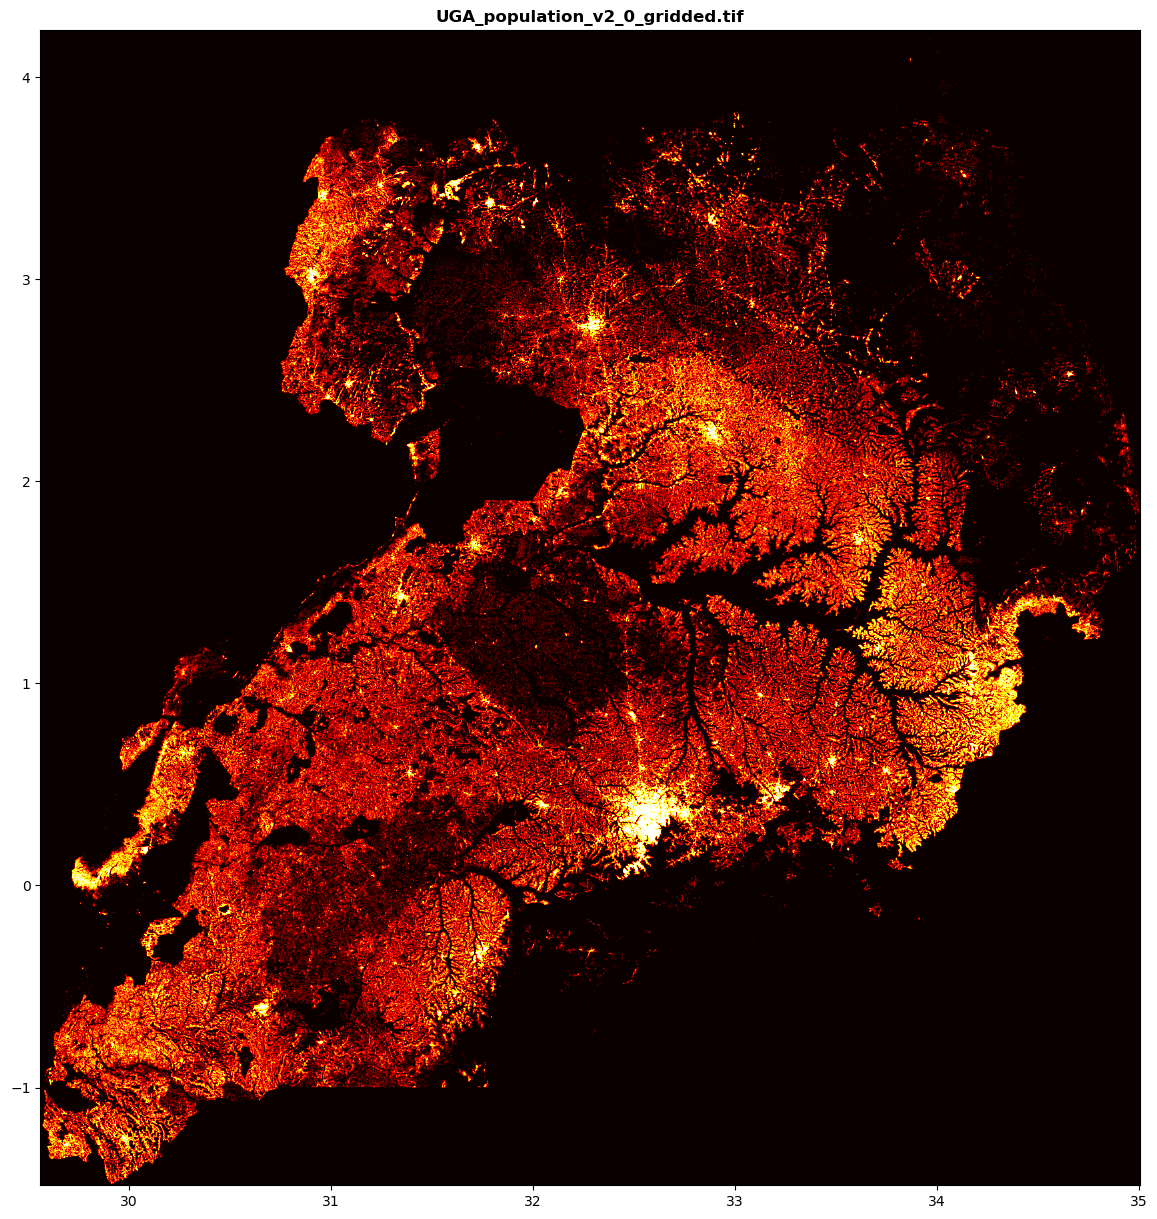

In [4]:
# Load the grid cells
gridded_buffers_gdf = gpd.read_file(PROCESSED_DATA_DIR / 'gridded_buffers_gdf.gpkg')
#get the bounds of the gridded_buffers
bounds = gridded_buffers_gdf.total_bounds


# Load population raster (all of UG)
with rasterio.open(population_tiff_path/'UGA_population_v2_0_gridded.tif') as src:
    # Read the raster data
    population_data = src.read(1)  # Read first band
    masked_data = np.ma.masked_where(population_data == src.nodata, population_data)
    # Or alternatively:
    # masked_data = np.ma.masked_equal(population_data, -99999.0)
    
    print(f"Raster shape: {population_data.shape}")
    print(f"Raster CRS: {src.crs}")
    print(f"NoData value: {src.nodata}")
    print(f"Resolution: {src.res}")
    print(f"Number of bands: {src.count}")
    print(f"Bands indexes: {src.indexes}")
    print(f"Band descriptions: {src.descriptions}")
    print(f"Band dtypes: {src.dtypes}")
    
    # Print population statistics with masked values
    print(f"\nPopulation Statistics (excluding NoData):")
    print(f"Min value: {masked_data.min()}")
    print(f"Max value: {masked_data.max()}")
    print(f"Mean value: {masked_data.mean()}")
    print(f"Number of valid pixels: {masked_data.count()}")
    print(f"Number of NoData pixels: {masked_data.mask.sum()}")
    
    # Additional statistics
    print(f"\nAdditional Statistics:")
    print(f"Median value: {np.ma.median(masked_data)}")
    print(f"Standard deviation: {masked_data.std()}")
    print(f"Sum of all values: {masked_data.sum()}")

    # Try plotting 

    # Create figure and plot
    fig, ax = plt.subplots(figsize=(15, 15))
    
    image = show(population_data, 
                 transform=src.transform,
                 ax=ax,
                 cmap='hot',
                 title='UGA_population_v2_0_gridded.tif')
    
    # Display the plot
    display(fig)
    plt.close(fig)


In [5]:
#clipping the raster file. 

def clip_raster_by_station(
    population_tiff_path: Path,
    output_dir: Path,
    gridded_buffers_gdf,
    station_name: str,
    buffer_km: float,
    plot: bool = True,
    overwrite: bool = False
) -> Path:
    """
    Clips a raster file based on station name and buffer size from a geodataframe gridded_buffers_gdf.
    
    Parameters:
    -----------
    population_tiff_path : Path
        Path to the input population raster file
    output_dir : Path
        Directory where the clipped raster will be saved
    gridded_buffers_gdf : GeoDataFrame
        Geodataframe containing the buffer geometries
    station_name : str
        Name of the radio station to clip by
    buffer_km : float
        Buffer size in kilometers to use for clipping
    plot : bool, optional
        Whether to create and display a plot of the clipped raster (default: True)
    overwrite : bool, optional
        Whether to overwrite existing files (default: False)
    
    Returns:
    --------
    Path
        Path to the clipped raster file
    """
    # Create output directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Filter the geodataframe for the specific station and buffer size
    station_mask = (gridded_buffers_gdf['station_name'] == station_name) & \
                  (gridded_buffers_gdf['buffer_km'] == buffer_km)
    
    filtered_gdf = gridded_buffers_gdf[station_mask]
    
    if filtered_gdf.empty:
        raise ValueError(f"No data found for station '{station_name}' with buffer size {buffer_km}km")
    
    # Create output filename
    output_filename = f"{station_name.replace(' ', '_')}_{int(buffer_km)}km_clipped.tif"
    clipped_raster_path = output_dir / output_filename
    #check if crs is the same. 
    # Process if the file doesn't exist or overwrite is True
    if not clipped_raster_path.exists() or overwrite:
               

        # Clip the raster
        with rasterio.open(population_tiff_path) as src:
            if filtered_gdf.crs==src.crs: 
                print("CRS of tiff and gdf is the same")

            # Get the geometry union for all matching grid cells
            geometry = filtered_gdf.geometry.union_all()
            
            # Perform the clipping
            out_image, out_transform = mask(src, [geometry], crop=True)
            
            # Update the metadata
            out_meta = src.meta.copy()
            out_meta.update({
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform
            })
            
            # Save the clipped raster
            with rasterio.open(clipped_raster_path, "w", **out_meta) as dest:
                dest.write(out_image)
                
        print(f"{'Overwrote' if overwrite and clipped_raster_path.exists() else 'Created'} clipped raster: {clipped_raster_path}")
    else:
        print(f"Using existing clipped raster: {clipped_raster_path}")
    
    # Print statistics and create plot if requested
    if plot:
        with rasterio.open(clipped_raster_path) as src:
            # Read and mask the data
            population_data = src.read(1)
            masked_data = np.ma.masked_where(population_data == src.nodata, population_data)
            
            # Print statistics
            print(f"\nStatistics for {station_name} ({buffer_km}km buffer):")
            print(f"Raster shape: {src.shape}")
            print(f"CRS: {src.crs}")
            print(f"Resolution: {src.res}")
            print(f"\nPopulation Statistics (excluding NoData):")
            print(f"Min value: {masked_data.min()}")
            print(f"Max value: {masked_data.max()}")
            print(f"Mean value: {masked_data.mean()}")
            print(f"Median value: {np.ma.median(masked_data)}")
            print(f"Standard deviation: {masked_data.std()}")
            print(f"Total population: {masked_data.sum()}")
            print(f"Valid pixels: {masked_data.count()}")
            print(f"NoData pixels: {masked_data.mask.sum()}")
            
            # Create and display plot
            fig, ax = plt.subplots(figsize=(15, 15))
            
            # Plot the raster
            show(population_data,
                 transform=src.transform,
                 ax=ax,
                 cmap='hot',
                 title=f'Population Distribution - {station_name} ({buffer_km}km buffer)')
            
            # Plot the buffer boundaries
            filtered_gdf.plot(ax=ax, facecolor='none', edgecolor='green', linewidth=0.25)
            
            plt.show()
            plt.close(fig)
    
    return clipped_raster_path


# clipped_file = clip_raster_by_station(
#     population_tiff_path=population_tiff_path/'UGA_population_v2_0_gridded.tif',
#     output_dir=PROCESSED_DATA_DIR,
#     gridded_buffers_gdf=gridded_buffers_gdf,
#     station_name='Aisa FM',
#     buffer_km=20.0,
#     plot=True,  # Will show the plot and statistics
#     overwrite=True  # Won't overwrite if file exists
# )






In [6]:

def calculate_grid_statistics_fast(grid_gdf, raster_path, cell_size_meters=1000):
    """
    Faster version of grid statistics calculation using pre-clipped raster
    """
    with rasterio.open(raster_path) as src:
        # Get the raster metadata
        width = src.width
        height = src.height
        
        # Calculate the total number of pixels in the raster
        total_pixels = width * height
        
        # Calculate zonal statistics on clipped raster
        stats = zonal_stats(grid_gdf,
                           raster_path,
                           stats=['count', 'nodata', 'sum'],
                           nodata=src.nodata,
                           all_touched=False)
    
    # Process results
    stats_df = pd.DataFrame(stats)
    stats_df['grid_id'] = grid_gdf['grid_id'].values
    stats_df['station_name']=grid_gdf['station_name'].values
    stats_df['buffer_km']=grid_gdf['buffer_km'].values
    stats_df['valid_pixels'] = stats_df['count']
    stats_df['nodata_pixels'] = stats_df['nodata']
    stats_df['total_pixels'] = stats_df['valid_pixels'] + stats_df['nodata_pixels']
    stats_df['prop_nodata'] = stats_df['nodata_pixels']/stats_df['total_pixels']
    stats_df['population_count']=stats_df['sum']
    


    
    return stats_df



In [7]:
# #one station name for testing
# station_name='Aisa FM'
# buffer_km=20.0
# station_mask = (gridded_buffers_gdf['station_name'] == station_name) & \
#                   (gridded_buffers_gdf['buffer_km'] == buffer_km)
# filtered_buffer_gdf = gridded_buffers_gdf[station_mask]

## processing function for selected stations. 

def process_selected_stations_to_dict(
    population_tiff_path: Path,
    output_dir: Path,
    gridded_buffers_gdf,
    station_names: list,
    buffer_values: list,
    overwrite: bool = False,
    plot: bool = False
) -> dict:
    """
    Process specified stations and buffer combinations, returning a dictionary of DataFrames
    
    Parameters:
    -----------
    population_tiff_path : Path
        Path to the population raster file
    output_dir : Path
        Directory for output files
    gridded_buffers_gdf : GeoDataFrame
        Geodataframe containing the buffer geometries
    station_names : list
        List of station names to process
    buffer_values : list
        List of buffer values (in km) to process
    overwrite : bool, optional
        Whether to overwrite existing files
    plot : bool, optional
        Whether to show plots for each combination
    
    Returns:
    --------
    dict
        Dictionary with (station_name, buffer_km) tuples as keys and statistics DataFrames as values
    """
    stats_dict = {}
    
    for station_name in station_names:
        for buffer_km in buffer_values:
            # Check if this combination exists in the geodataframe
            station_mask = (gridded_buffers_gdf['station_name'] == station_name) & \
                         (gridded_buffers_gdf['buffer_km'] == buffer_km)
            
            if not station_mask.any():
                print(f"Skipping: No data for {station_name} at {buffer_km}km")
                continue
                
            try:
                # Clip the raster
                clipped_file = clip_raster_by_station(
                    population_tiff_path=population_tiff_path,
                    output_dir=output_dir,
                    gridded_buffers_gdf=gridded_buffers_gdf,
                    station_name=station_name,
                    buffer_km=buffer_km,
                    plot=plot,
                    overwrite=overwrite
                )
                
                # Filter the geodataframe for this station/buffer combination
                station_gdf = gridded_buffers_gdf[station_mask]
                
                # Calculate statistics
                stats_df = calculate_grid_statistics_fast(
                    grid_gdf=station_gdf,
                    raster_path=clipped_file
                )
                
                # Store in dictionary
                stats_dict[(station_name, buffer_km)] = stats_df
                
                print(f"Processed {station_name} at {buffer_km}km")
                
            except Exception as e:
                print(f"Error processing {station_name} at {buffer_km}km: {str(e)}")
    
    return stats_dict



In [8]:
# Time the execution
# start_time = time.time()

# grid_stats = calculate_grid_statistics_fast(
#     filtered_buffer_gdf, 
#     PROCESSED_DATA_DIR/'Aisa_FM_20km_clipped.tif' 
# )

# print(f"Execution time: {time.time() - start_time:.2f} seconds")


In [9]:
station_names = 'Aisa FM', 'Dwanwana FM', 'Dokolo FM'
buffer_values = [20.0, 25.0]


Using existing clipped raster: c:\Users\linss\OneDrive\Documents\Projects\lm_listnership_sampling\data\temp\Aisa_FM_20km_clipped.tif

Statistics for Aisa FM (20.0km buffer):
Raster shape: (435, 432)
CRS: EPSG:4326
Resolution: (0.0008333300000000002, 0.0008333300000000002)

Population Statistics (excluding NoData):
Min value: 4.014623165130615
Max value: 34.745113372802734
Mean value: 8.733402513741373
Median value: 7.6462931632995605
Standard deviation: 3.1680555894321496
Total population: 422644.28125
Valid pixels: 48394
NoData pixels: 139526


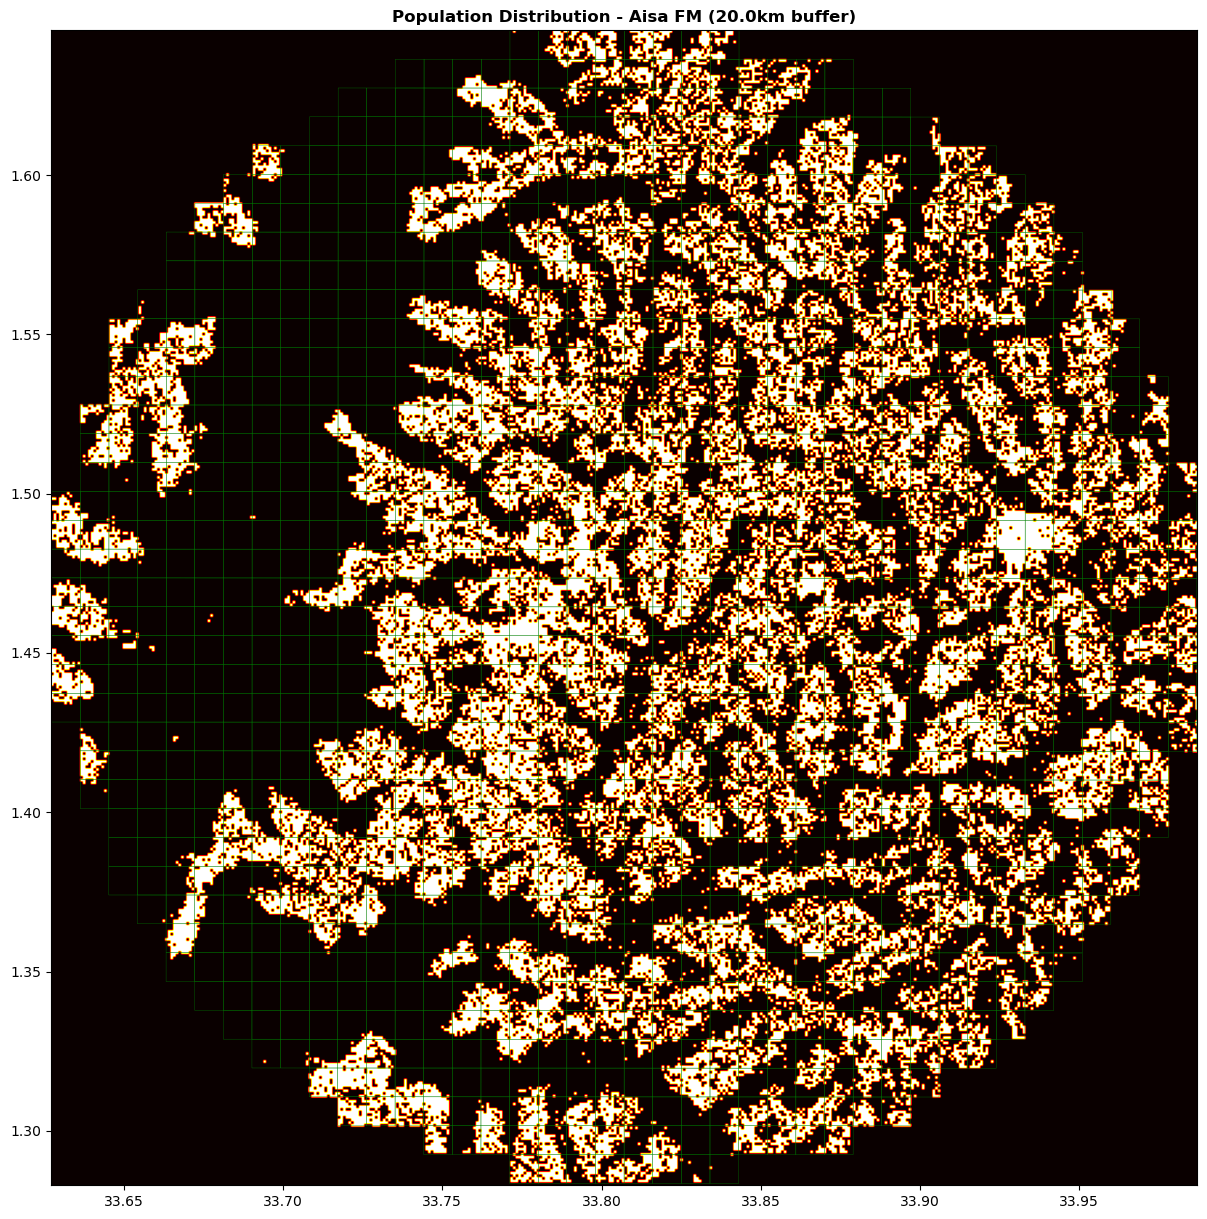

Processed Aisa FM at 20.0km
Using existing clipped raster: c:\Users\linss\OneDrive\Documents\Projects\lm_listnership_sampling\data\temp\Aisa_FM_25km_clipped.tif

Statistics for Aisa FM (25.0km buffer):
Raster shape: (544, 540)
CRS: EPSG:4326
Resolution: (0.0008333300000000002, 0.0008333300000000002)

Population Statistics (excluding NoData):
Min value: 3.802847146987915
Max value: 35.252803802490234
Mean value: 8.982094264582752
Median value: 7.920044898986816
Standard deviation: 3.3744921020536167
Total population: 643656.875
Valid pixels: 71660
NoData pixels: 222100


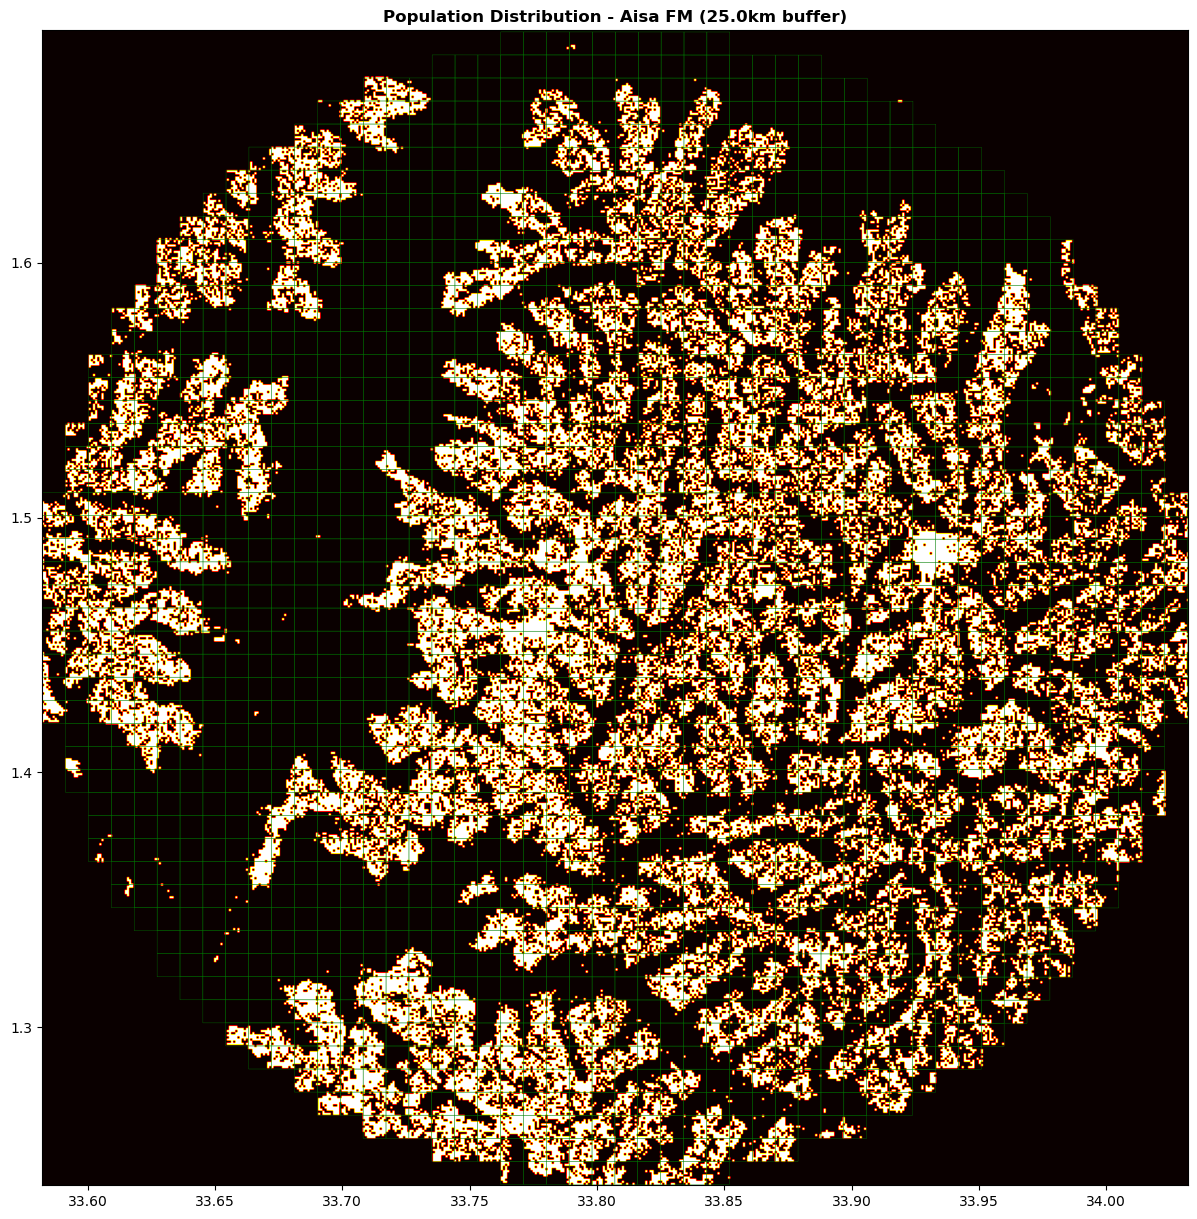

Processed Aisa FM at 25.0km
Using existing clipped raster: c:\Users\linss\OneDrive\Documents\Projects\lm_listnership_sampling\data\temp\Dwanwana_FM_20km_clipped.tif

Statistics for Dwanwana FM (20.0km buffer):
Raster shape: (436, 433)
CRS: EPSG:4326
Resolution: (0.0008333300000000002, 0.0008333300000000002)

Population Statistics (excluding NoData):
Min value: 3.6394197940826416
Max value: 24.89434051513672
Mean value: 6.427309837472239
Median value: 5.44874906539917
Standard deviation: 2.115924282385255
Total population: 318344.65625
Valid pixels: 49530
NoData pixels: 139258


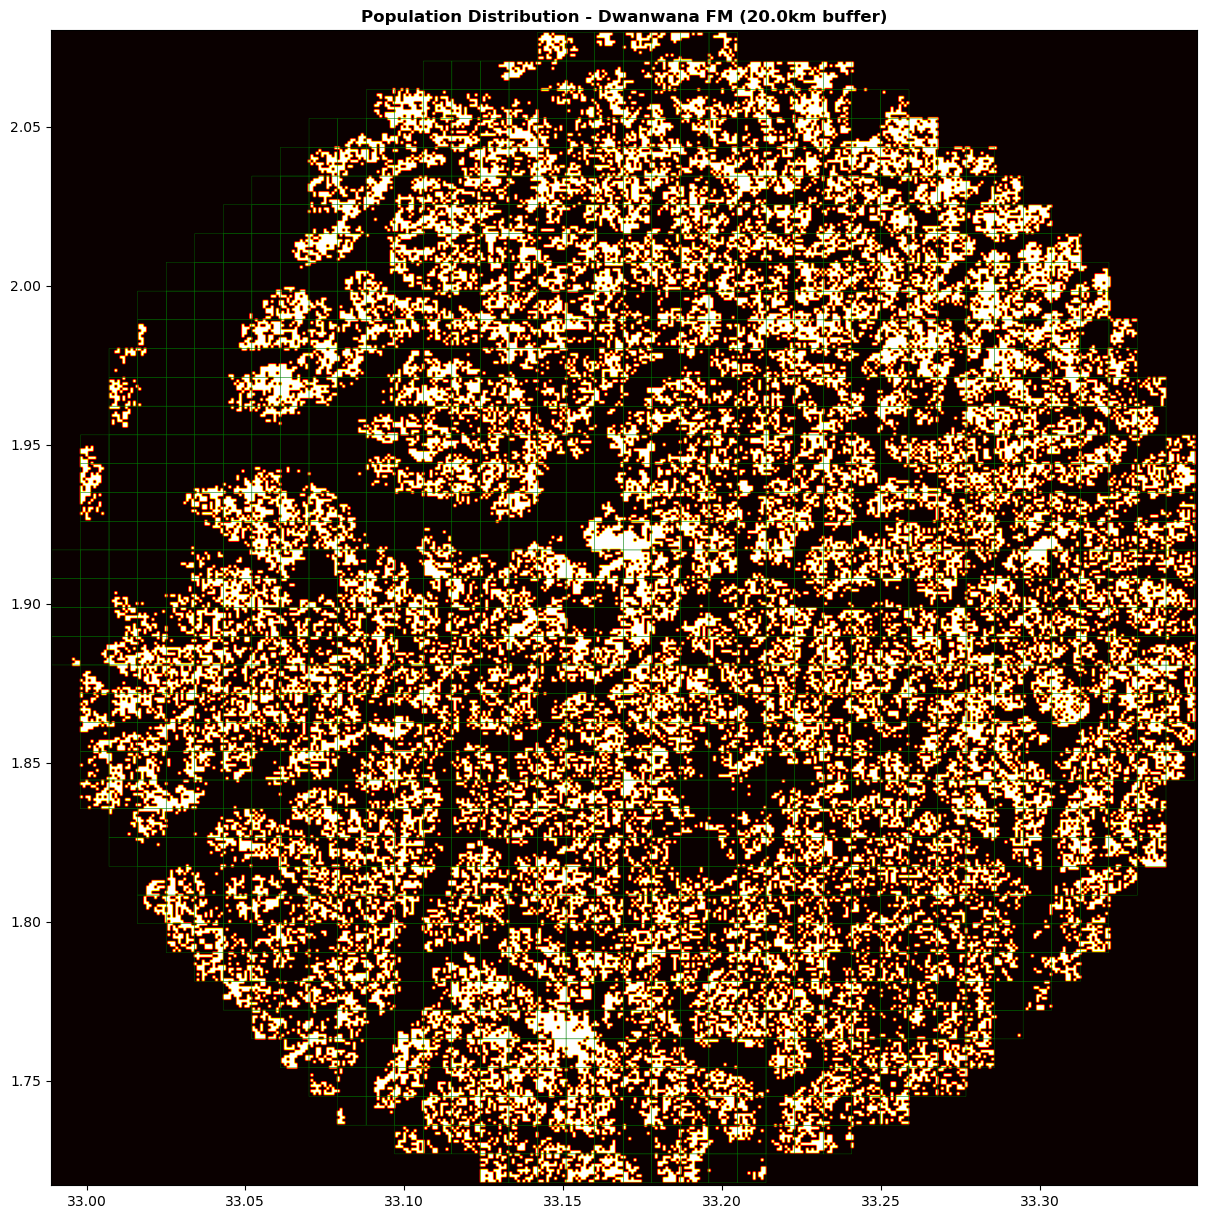

Processed Dwanwana FM at 20.0km
Using existing clipped raster: c:\Users\linss\OneDrive\Documents\Projects\lm_listnership_sampling\data\temp\Dwanwana_FM_25km_clipped.tif

Statistics for Dwanwana FM (25.0km buffer):
Raster shape: (544, 541)
CRS: EPSG:4326
Resolution: (0.0008333300000000002, 0.0008333300000000002)

Population Statistics (excluding NoData):
Min value: 3.026705741882324
Max value: 24.89434051513672
Mean value: 6.295166913996401
Median value: 5.396942615509033
Standard deviation: 2.0696515573011487
Total population: 468750.71875
Valid pixels: 74462
NoData pixels: 219842


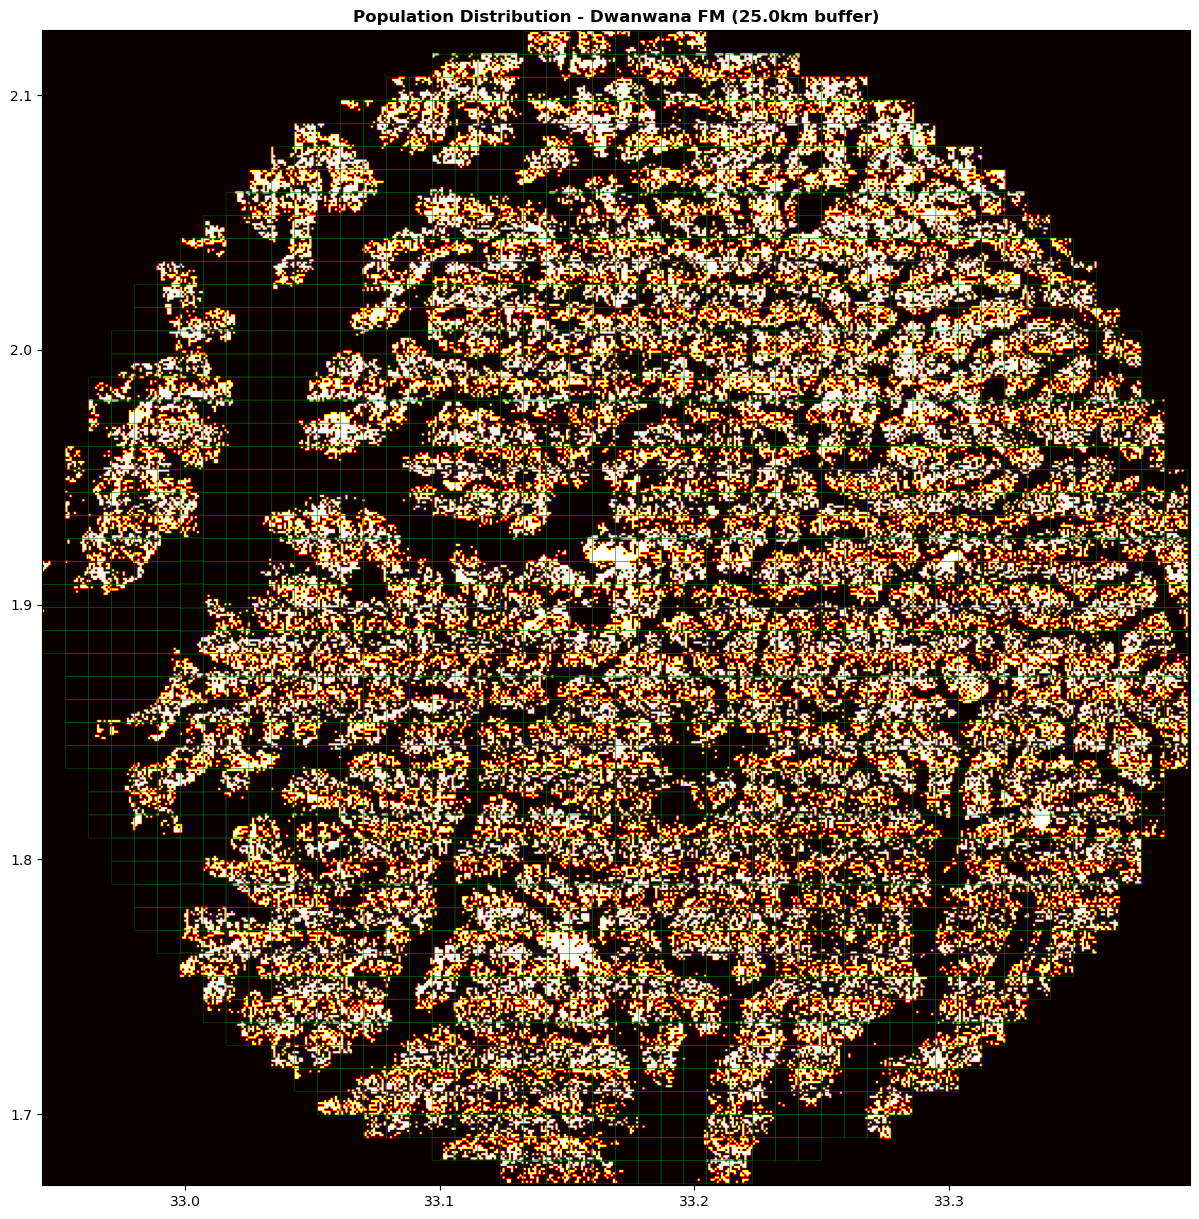

Processed Dwanwana FM at 25.0km
Using existing clipped raster: c:\Users\linss\OneDrive\Documents\Projects\lm_listnership_sampling\data\temp\Dokolo_FM_20km_clipped.tif

Statistics for Dokolo FM (20.0km buffer):
Raster shape: (425, 433)
CRS: EPSG:4326
Resolution: (0.0008333300000000002, 0.0008333300000000002)

Population Statistics (excluding NoData):
Min value: 3.6394197940826416
Max value: 24.89434051513672
Mean value: 6.433985900161492
Median value: 5.446135997772217
Standard deviation: 2.1273811142458845
Total population: 314744.15625
Valid pixels: 48919
NoData pixels: 135106


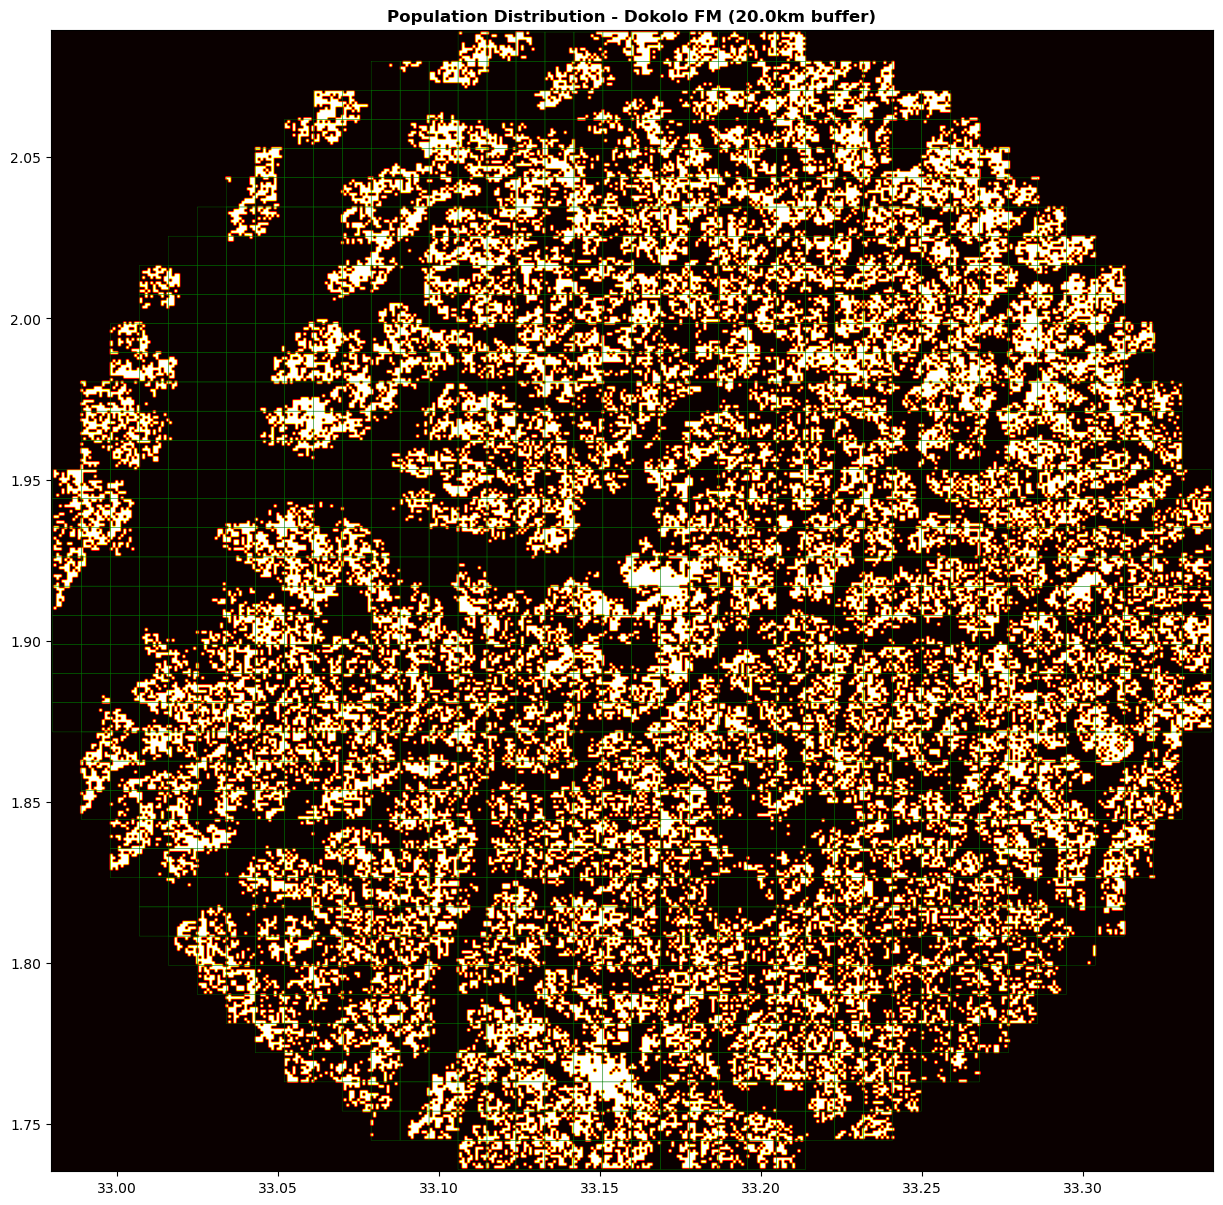

Processed Dokolo FM at 20.0km
Using existing clipped raster: c:\Users\linss\OneDrive\Documents\Projects\lm_listnership_sampling\data\temp\Dokolo_FM_25km_clipped.tif

Statistics for Dokolo FM (25.0km buffer):
Raster shape: (533, 541)
CRS: EPSG:4326
Resolution: (0.0008333300000000002, 0.0008333300000000002)

Population Statistics (excluding NoData):
Min value: 3.026705741882324
Max value: 24.89434051513672
Mean value: 6.287830742182764
Median value: 5.398733139038086
Standard deviation: 2.081635324769792
Total population: 466726.8125
Valid pixels: 74227
NoData pixels: 214126


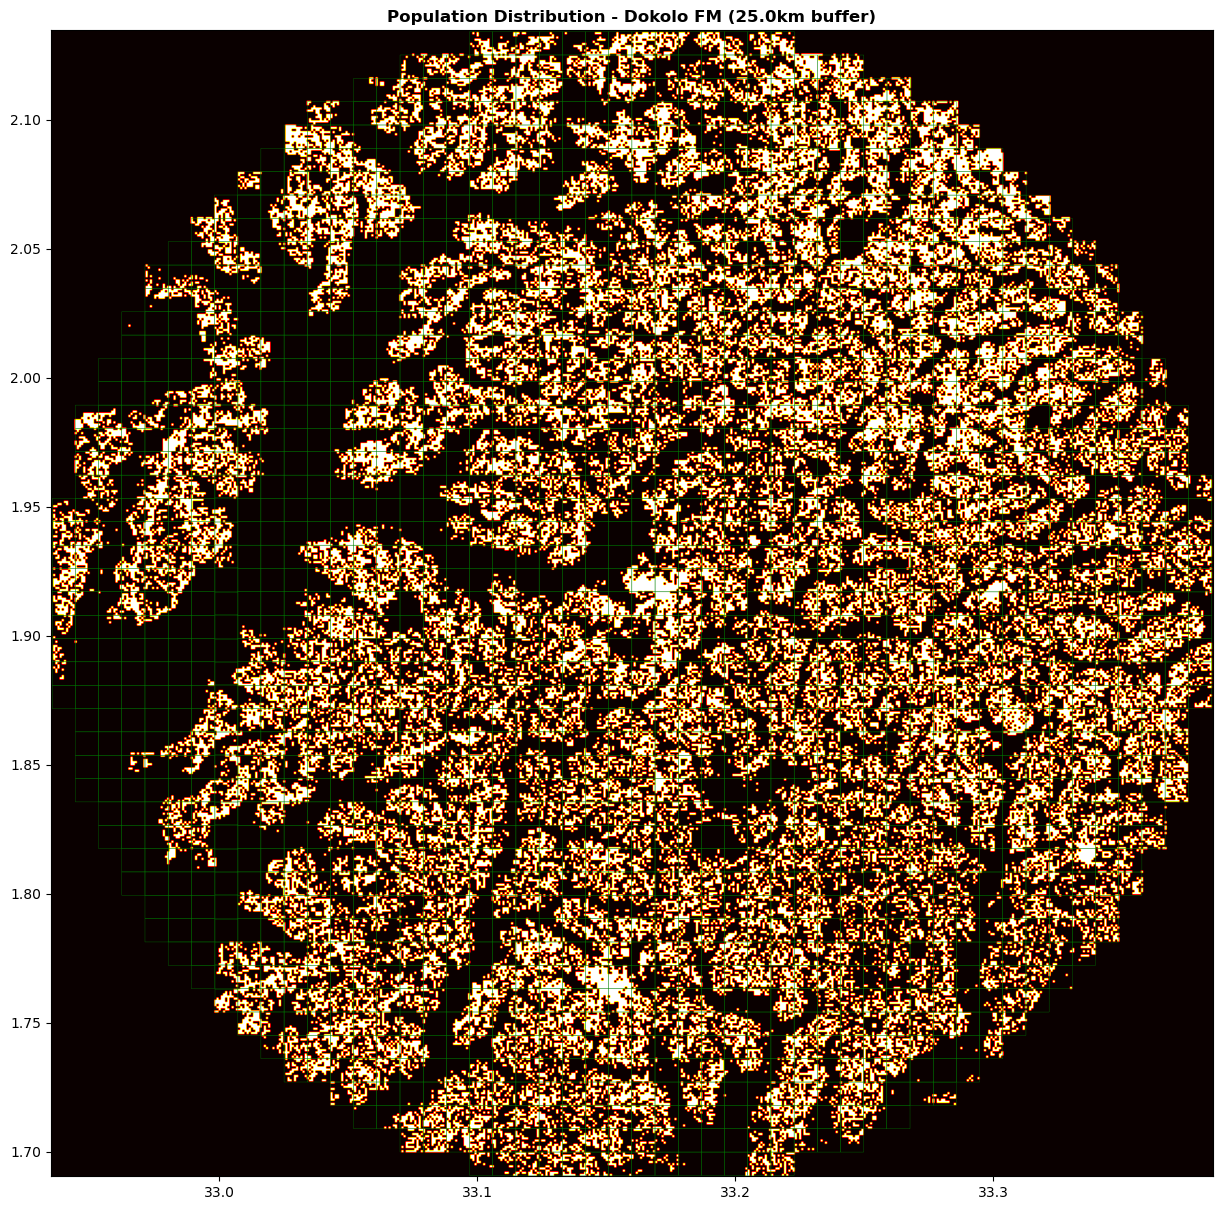

Processed Dokolo FM at 25.0km


In [10]:
results = process_selected_stations_to_dict(
    population_tiff_path=population_tiff_path/'UGA_population_v2_0_gridded.tif',
    output_dir=TEMP_DATA_DIR,
    gridded_buffers_gdf=gridded_buffers_gdf,
    station_names=station_names,
    buffer_values=buffer_values,
    overwrite=False,  # Set to True if you want to recreate existing files
    plot=True  # Set to True if you want to see the plots
)


In [11]:
all_results = pd.concat([df.assign(station_name=station, buffer_km=buffer) 
                        for (station, buffer), df in results.items()])

# Save to file
all_results.to_csv(PROCESSED_DATA_DIR/'station_population_data.csv', index=False)



In [12]:
all_results

count         sum  nodata  grid_id station_name  buffer_km  \
0        23  216.643463    87.0    21461      Aisa FM       20.0   
1        58  700.665894    42.0    21291      Aisa FM       20.0   
2        10   87.026184   111.0    21462      Aisa FM       20.0   
3        80  864.314026    30.0    21292      Aisa FM       20.0   
4        76  793.443115    45.0    21122      Aisa FM       20.0   
...     ...         ...     ...      ...          ...        ...   
1949     66  340.077698    55.0    12370    Dokolo FM       25.0   
1950     51  233.072800    70.0    12200    Dokolo FM       25.0   
1951     82  412.326538    39.0    12030    Dokolo FM       25.0   
1952     56  270.777649    65.0    12201    Dokolo FM       25.0   
1953     50  222.233871    71.0    12031    Dokolo FM       25.0   

      valid_pixels  nodata_pixels  total_pixels  prop_nodata  population_count  
0               23           87.0         110.0     0.790909        216.643463  
1               58           42.0         100.0     0.420000        700.665894  
2               10          111.0         121.0     0.917355         87.026184  
3               80           30.0         110.0     0.272727        864.314026  
4               76           45.0         121.0     0.371901        793.443115  
...            ...            ...           ...          ...               ...  
1949            66           55.0         121.0     0.454545        340.077698  
1950            51           70.0         121.0     0.578512        233.072800  
1951            82           39.0         121.0     0.322314        412.326538  
1952            56           65.0         121.0     0.537190        270.777649  
1953            50           71.0         121.0     0.586777        222.233871  

[9651 rows x 11 columns]